In [110]:
import os
import networkx as nx
import numpy as np
import random
import matplotlib
import requests
import matplotlib.pyplot as plt
import powerlaw

from collections import Counter

In [112]:

# Download function
def download_file(data_url, data_file):
    with requests.get(data_url, stream=True) as r:
        r.raise_for_status()
        with(open(data_file, 'wb')) as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return data_file

# Generator of infinit sequence
def infinite_sequence():
    num = 0
    while True:
        yield num
        num += 1

# Import graph function
def import_graph(G, num_gen, word_dict):
    for word in word_dict:
        try:
            first_word, second_word = word.strip('\n'.encode()).decode('UTF-8').split(' ')
        except ValueError as e:
            continue
        if not G.has_node(first_word):
            G.add_node(first_word)
            G.nodes[first_word]['label'] = next(num_gen)
        if not G.has_node(second_word):
            G.add_node(second_word)
            G.nodes[second_word]['label'] = next(num_gen)
        G.add_edge(first_word, second_word)

In [114]:
data_url = 'https://www.ia.pw.edu.pl/~mkamola/dataset-big/0.txt'
data_file_name = 'dataset_0.txt'

data_file = data_file_name if os.path.exists(data_file_name) else download_file(data_url, data_file_name)
word_dict = (word for word in open(data_file, 'rb'))

# Wczytanie danych do grafu, który ma możliwość powtórzenia krawędzi
G = nx.read_edgelist(data_file, create_using=nx.MultiGraph)

print('Multi graph info:')
print(nx.info(G))
print('\n')

# Usuwamy krawędzi powtarzające
G = nx.Graph(G)

# Usuwamy pętli z grafu
G.remove_edges_from(nx.selfloop_edges(G))

print('Edited graph info:')
print(nx.info(G))
print('\n')

# Największa składowa spójna
print('Size of the biggest component: ')
G0 = G.subgraph(max(nx.connected_components(G), key=len))
print(nx.info(G0))
print('\n')

Multi graph info:
Name: 
Type: MultiGraph
Number of nodes: 64738
Number of edges: 258236
Average degree:   7.9779


Edited graph info:
Name: 
Type: Graph
Number of nodes: 64738
Number of edges: 242408
Average degree:   7.4889


Size of the biggest component: 
Name: 
Type: Graph
Number of nodes: 64268
Number of edges: 242157
Average degree:   7.5358




In [116]:
# Aproksymacja średniej długości ścieżki
ks = [100, 1000, 10000]
for k in ks:
    sampled_nodes = random.sample(G0.nodes, k) # wylosuj wierzchołki
    sampled_graph = G0.subgraph(sampled_nodes) # stwórz podgraf na ich bazie
    biggest_cc = max(nx.connected_components(sampled_graph), key=len)
    G_big = sampled_graph.subgraph(biggest_cc)
    print(nx.info(G_big))
    try:
        res = nx.average_shortest_path_length(G_big)
        print('The response is:')
        print(res)
    except nx.NetworkXError as e:
        res = 0
        print('\n')
        print(e)
    print('\n')

15-core info
Name: 
Type: Graph
Number of nodes: 1205
Number of edges: 15961
Average degree:  26.4913


14-core info
Name: 
Type: Graph
Number of nodes: 2285
Number of edges: 30677
Average degree:  26.8508


13-core info
Name: 
Type: Graph
Number of nodes: 3192
Number of edges: 42189
Average degree:  26.4342




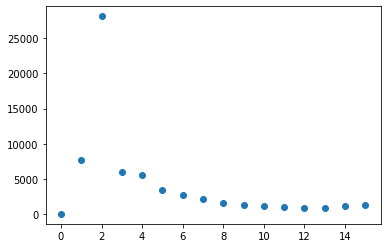

In [118]:
core_numbers = nx.core_number(G)

deg_dict = Counter(core_numbers)
degs = deg_dict.keys()
freqs = deg_dict.values()

sorted_freqs = sorted(list(dict.fromkeys(freqs)), reverse=True)

# Liczbę rdzeni o największym możliwym rzędzie, o drugim możliwie największym rzędzie o trzecim możliwie największym rzędzie;
for i in list(sorted_freqs)[:3]:
    print(str(i) + '-core info')
    print(nx.info(nx.k_core(G, k=i)))
    print('\n')

hist_data = sorted(Counter(core_numbers.values()).items())
# rozkład stopni wierzchołków
plt.scatter(*zip(*hist_data))



Not enough data. Returning nan
Not enough data. Returning nan


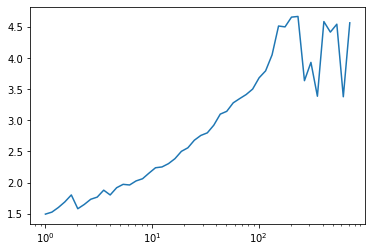

In [120]:
dlist = G0.degree()
dlist = [elem[1] for elem in dlist]

NBINS = 50
bins=np.logspace(np.log10(min(dlist)),
                 np.log10(max(dlist)), num=NBINS)
bcnt, bedge=np.histogram(np.array(list(dlist)),bins=bins)
alpha=np.zeros(len(bedge[:-2]))

for i in range(0,len(bedge)-2):
    fit=powerlaw.Fit(list(dlist), xmin=bedge[i], discrete=True)
    alpha[i]=fit.alpha
    
plt.semilogx(bedge[:-2],alpha)


In [121]:
deg_dict = Counter(dlist)
degs = deg_dict.keys()
freqs = deg_dict.values()
plt.loglog(degs, freqs, 'bo')
plt.gcf().savefig('degree_freq.png')
plt.close()

In [122]:
import scipy.stats as st

dlist = G0.degree()
dlist = [elem[1] for elem in dlist]

dlist = dict(Counter(dlist))

log_dlist = dlist.keys()

print(type(log_dlist))

log_dlist = np.log10(list(dlist.keys()))
log_ylist = np.log10(list(dlist.values()))

st.linregress(log_dlist, log_ylist)

<class 'dict_keys'>


LinregressResult(slope=-2.0922248192786275, intercept=5.054751275840356, rvalue=-0.9642377914771526, pvalue=1.0697579244812132e-127, stderr=0.0389497927232805)